## INITIALISATION

### IMPORTS

In [1]:
import ollama
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

### GLOBAL VARIABLES

In [2]:
action_df = pd.read_csv("df_csv/action_dataset.csv", header=0)
with open('french_stop_words.txt', 'r') as f:
    STOP_WORDS = f.read().splitlines()

MODEL_NAME = 'aya'
ACTION_LABELS = action_df['action'].dropna().unique()
TEST_SENTENCES = action_df['assistant_sentence']
TEST_WORDS = None
N_DIM = 50

### FUNCTIONS

In [3]:
def embedding_func(text: str) -> np.ndarray:
    return np.array(ollama.embeddings(model=MODEL_NAME, prompt=text)['embedding'])

def cosine_similarity(a: np.ndarray, b: np.ndarray) -> float:
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

def get_save_embeddings(file_name: str, text_iterable: list):
    if os.path.exists(file_name):
        with open(file_name, 'rb') as f:
            embeddings = np.load(f)
    else:
        embeddings = np.array([embedding_func(sentence) for sentence in tqdm(text_iterable)])
        # save the embeddings
        with open(file_name, 'wb') as f:
            np.save(f, embeddings)
    
    return embeddings

def extract_vocabulary(text_iterable: list, stop_words: list = STOP_WORDS):
    if stop_words is None:
        stop_words = []
    vocabulary = set()
    for text in text_iterable:
        words = text.split()
        for word in words:
            if word not in stop_words:
                vocabulary.add(word)
    return vocabulary

def new_words(text:str, stop_words: list = STOP_WORDS) -> list:
    chars_to_replace_with_space = ['?', '!', '.', ',', ';', "'", '"']
    words = text.lower()
    for char in chars_to_replace_with_space:
        words = words.replace(char, ' ')
    words = words.split()
    return extract_vocabulary(words, stop_words)

def new_phrase(text:str, stop_words: list = STOP_WORDS) -> str:
    return ' '.join(new_words(text, stop_words))

def print_bad_predictions(y_test, y_pred, X_test, X):
    # print all bad predictions, sentence and label
    print("\nBAD PREDICTIONS", "-"*50)
    print("Sentence - True Label - Predicted Label")
    for i in range(len(y_pred)):
        if y_pred[i] != y_test.iloc[i]:
            # find index in X_pca where X_test[i] is
            index = np.where((X == X_test[i]).all(axis=1))[0][0]
            print(f"-  {TEST_SENTENCES.iloc[index]} - {y_test.iloc[i]} - {y_pred[i]}")

def encode_y(y_str, dict_str_int):
    return np.array([dict_str_int[label] for label in y_str])

def decode_y(y_int, dict_int_str):
    return np.array([dict_int_str[label] for label in y_int])

In [4]:
print(embedding_func('The quick brown fox jumps over the lazy fog')) # test embedding function so the model is loaded

print(TEST_SENTENCES[0])
print(new_phrase(TEST_SENTENCES[0]))

[-7.38868952  5.99665213 -9.11465073 ... -1.09154022 12.75729847
  6.15325594]
Je connais quelques endroits sympas près de l'entreprise pour déjeuner.
entreprise connais sympas endroits déjeuner quelques près


In [5]:
sentences_words = TEST_SENTENCES.apply(new_words)
# count = {i : len(sentences_words[i]) for i in range(len(sentences_words))}

count = 0
dict_senteces_word_indexes = dict()
for i in range(len(sentences_words)):
    for j in range(len(sentences_words[i])):
        dict_senteces_word_indexes[count] = (i, j)
        count += 1

TEST_WORDS = np.array([word for words in sentences_words for word in words])

##### plot

In [6]:
def break_sentence_into_lines(sentence: str, max_line_length: int = 20) -> str:
    words = sentence.split()
    lines = []
    line = ''
    for word in words:
        if len(line) + len(word) + 1 <= max_line_length:
            line += word + ' '
        else:
            lines.append(line)
            line = word + ' '
    lines.append(line)
    return '\n'.join(lines)

def pretty_print_matrix(matrix: np.ndarray, num_spaces: int = 2):
    for row in matrix:
        for cell in row:
            if round(cell, 2) == 0:
                print('0   ', end=' ' * num_spaces)
            else:
                print(f'{cell:.2f}', end=' ' * num_spaces)
        print()

# plot the t-SNE
def plot_2D(X, ax):
    cmap = plt.colormaps.get_cmap('tab10')
    for i, action_label in enumerate(ACTION_LABELS):

        mask = action_df['action'] == action_label
        ax.scatter(X[mask, 0], X[mask, 1], alpha=0.7, label=action_label, color=cmap(i))

        x_mean = X[mask, 0].mean()
        y_mean = X[mask, 1].mean()
        name_str = break_sentence_into_lines(" ".join(action_label.split("_")).title(), max_line_length=20)

        ax.text(x_mean, y_mean, name_str, horizontalalignment='center', verticalalignment='center', fontsize=10, fontstyle='italic', fontweight='bold', bbox=dict(facecolor='white', alpha=0.4), color=cmap(i))

    # other data (action_label not in the list)
    mask = ~action_df['action'].isin(ACTION_LABELS)
    ax.scatter(X[mask, 0], X[mask, 1], alpha=0.7, label="other", color='grey')


def plot_confusion_matrix(y, y_pred, labels, french=True):

    c_matrix = np.array(confusion_matrix(y, y_pred, labels=labels))

    fig, ax = plt.subplots()
    cmap = plt.colormaps.get('Blues')
    cax = ax.matshow(c_matrix, cmap=cmap)
    max_val = c_matrix.max()
    min_val = c_matrix.min()
    # text
    for (i, j), val in np.ndenumerate(c_matrix):
        if val == min_val:
            continue
        bg_color = cmap((val - min_val) / (max_val - min_val))
        luminance = 0.299 * bg_color[0] + 0.587 * bg_color[1] + 0.114 * bg_color[2]
        text_color = 'black' if luminance > 0.5 else 'white'
        ax.text(j, i, f"{val}", ha='center', va='center', color=text_color)

    # insert \n in labels when too long
    each_n = 24

    def insert_newlines(string, every=30):
        words = string.split()
        # if the combined length of the words is less than the every parameter
        if len(' '.join(words)) < every:
            return ' '.join(words)
        
        # if the combined length of the words is greater than the every parameter
        new_string = ''
        current_length = 0
        for word in words:
            if current_length + len(word) > every:
                new_string += '\n'
                current_length = 0
            new_string += word + ' '
            current_length += len(word) + 1
        return new_string

    plt_labels = [labels[i] if len(labels[i]) < each_n else insert_newlines(labels[i], each_n) for i in range(len(labels))]
    if french:
        plt_labels = ['Inconnu' if label == 'Unknown' else label for label in plt_labels]

    ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)

    plt.xticks(range(len(labels)), range(len(labels)))
    plt.yticks(range(len(labels)), range(len(labels)))

    # text associating label number with label name
    for i in range(len(labels)):
        ax.text(len(labels), i, f"{i} - {plt_labels[i]}", ha='left', va='center', fontsize=10)

    ax.xaxis.set_label_position('top') 
    if french:
        plt.title('Matrice de confusion', pad=20, fontsize=15, fontweight='bold', color='black', y=-0.2)
        plt.xlabel('Action prédite')
        plt.ylabel('Action réelle')
    else:
        plt.title('Confusion matrix', pad=20, fontsize=15, fontweight='bold', color='black', y=-0.2)
        plt.xlabel('Predicted action')
        plt.ylabel('Actual action')
    plt.tight_layout()
    plt.show()

## COMPUTE EMBEDDINGS

In [7]:
action_embeddings = get_save_embeddings(f"embeddings/action_embeddings_{MODEL_NAME}.npy", ACTION_LABELS)

100%|██████████| 7/7 [00:00<00:00, 18.76it/s]


In [8]:
test_sentence_embeddings = get_save_embeddings(f"embeddings/test_sentence_embeddings_{MODEL_NAME}.npy", TEST_SENTENCES)

100%|██████████| 438/438 [00:38<00:00, 11.26it/s]


In [9]:
test_word_embeddings = get_save_embeddings(f"embeddings/test_word_embeddings_{MODEL_NAME}.npy", TEST_WORDS)

100%|██████████| 2179/2179 [01:14<00:00, 29.31it/s]


## COMPUTE PCA and TSNE

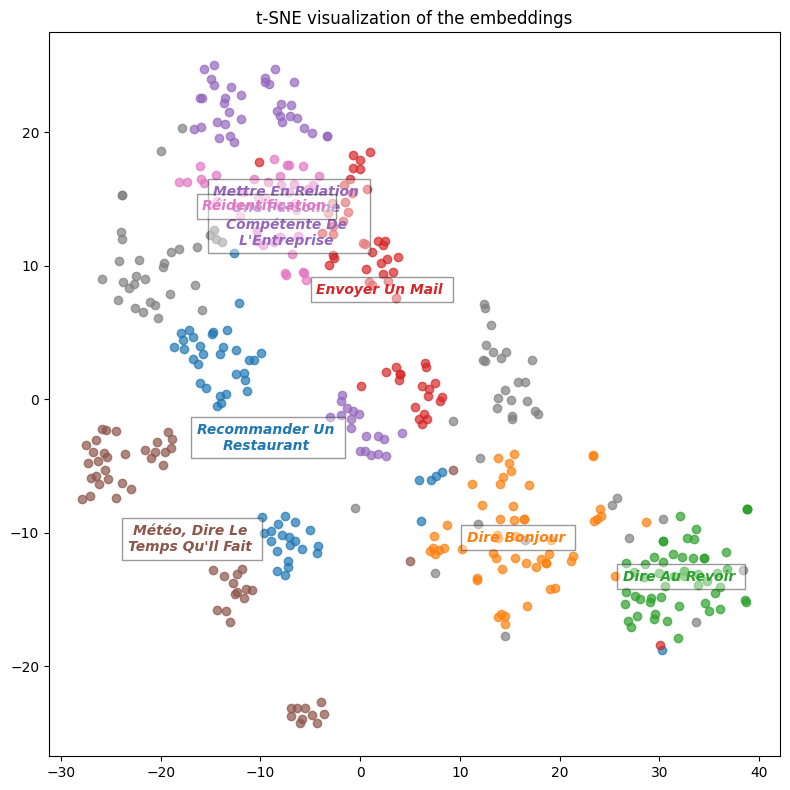

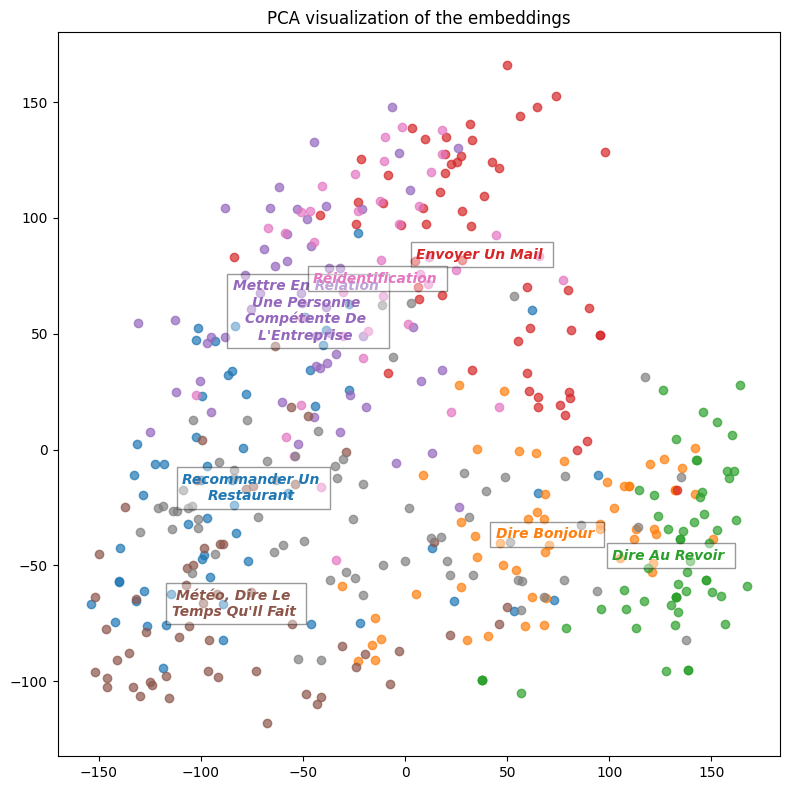

In [10]:
# tsne visualization of the embeddings

tsne = TSNE(n_components=2, random_state=0)
X_tsne = tsne.fit_transform(test_sentence_embeddings)

pca = PCA(n_components=2, random_state=0)
X_pca = pca.fit_transform(test_sentence_embeddings)


fig, ax = plt.subplots(figsize=(8, 8))
plot_2D(X_tsne, ax)
ax.set_title("t-SNE visualization of the embeddings")
plt.tight_layout()
plt.savefig("plots/tsne.png")
plt.show()


fig, ax = plt.subplots(figsize=(8, 8))
plot_2D(X_pca, ax)
ax.set_title("PCA visualization of the embeddings")
plt.tight_layout()
plt.savefig("plots/pca.png")
plt.show()


## CLASSIFICATION

### PREPROCESSING

In [11]:
test_sentence_similarity_file_name = f"embeddings/test_sentence_similarity_{MODEL_NAME}.npy"

if os.path.exists(test_sentence_similarity_file_name):
    with open(test_sentence_similarity_file_name, 'rb') as f:
        test_sentence_similarity = np.load(f)
else:
    test_sentence_similarity = np.array([[cosine_similarity(action_embedding, test_sentence_embedding) for test_sentence_embedding in test_sentence_embeddings] for action_embedding in action_embeddings])
    with open(test_sentence_similarity_file_name, 'wb') as f:
        np.save(f, test_sentence_similarity)

In [55]:
ponctuation_features = np.array([[(p in sentence) for p in ['.', ',', '?', '!']] for sentence in TEST_SENTENCES]).astype(float)

In [56]:
word_in_action_features = np.array([[np.any([word in action for word in words]) for action in ACTION_LABELS] for words in sentences_words]).astype(float)

In [12]:
tsne = TSNE(n_components=3, random_state=0)
X_tsne = tsne.fit_transform(test_sentence_embeddings)

pca = PCA(n_components=N_DIM, random_state=0)
X_pca = pca.fit_transform(test_sentence_embeddings)

In [58]:
print("SHAPES", "="*35)
print("  X_tsne                     ", X_tsne.shape)
print("  X_pca                      ", X_pca.shape)
print("  action_embeddings          ", action_embeddings.shape)
print("  test_sentence_embeddings   ", test_sentence_embeddings.shape)
print("  test_sentence_similarity   ", test_sentence_similarity.shape)
print("  ponctuation_features       ", ponctuation_features.shape)
print("  word_in_action_features    ", word_in_action_features.shape)

SHAPES ===================================
  X_tsne                      (438, 3)
  X_pca                       (438, 50)
  action_embeddings           (7, 4096)
  test_sentence_embeddings    (438, 4096)
  test_sentence_similarity    (7, 438)
  ponctuation_features        (438, 4)
  word_in_action_features     (438, 7)


In [65]:
X = np.concatenate([X_pca, test_sentence_similarity.T, ponctuation_features, word_in_action_features], axis=1)
scaler = StandardScaler()
X = scaler.fit_transform(X)
y_str = action_df['action']
# if y not in ACTION_LABELS, replace it with "Unknown"
# y = y.apply(lambda x: x if x in ACTION_LABELS else "Unknown")
y_str = y_str.fillna("Unknown")
dict_str_num = {label: i for i, label in enumerate(y_str.unique())}
dict_num_str = {i: label for i, label in enumerate(y_str.unique())}

X_train, X_test, y_train, y_test = train_test_split(X, y_str, test_size=0.2, random_state=0)

print("SHAPES", "="*15)
print("  X_train ", X_train.shape)
print("  X_test  ", X_test.shape)
print("  y_train ", y_train.shape)
print("  y_test  ", y_test.shape)

SHAPES ===============
  X_train  (350, 68)
  X_test   (88, 68)
  y_train  (350,)
  y_test   (88,)


### SIMILARITY

#### sentence to action

Accuracy: 0.32


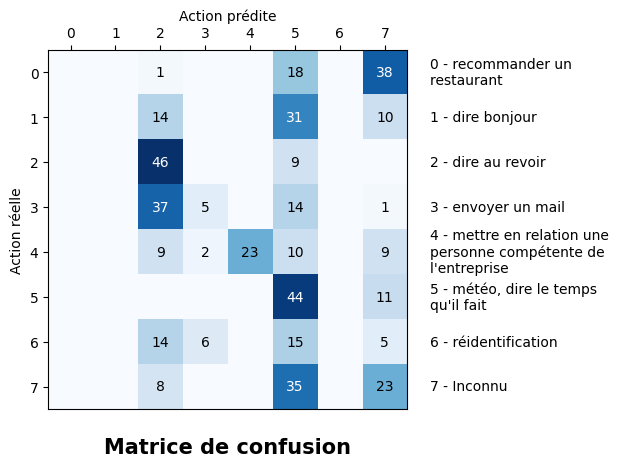


BAD PREDICTIONS --------------------------------------------------
Sentence - True Label - Predicted Label
-  Je connais quelques endroits sympas près de l'entreprise pour déjeuner. - recommander un restaurant - Unknown
-  Envie de découvrir de nouveaux restaurants à proximité ? - recommander un restaurant - Unknown
-  Besoin d'une idée pour déjeuner près d'ici ? - recommander un restaurant - météo, dire le temps qu'il fait
-  Tu cherches un bon endroit où manger dans le coin ? - recommander un restaurant - Unknown
-  Je peux te donner quelques suggestions de restaurants à proximité. - recommander un restaurant - Unknown
-  Tu veux des recommandations pour le déjeuner près du bureau ? - recommander un restaurant - météo, dire le temps qu'il fait
-  Besoin d'une pause déjeuner gourmande près d'ici ? - recommander un restaurant - Unknown
-  Je sais où trouver de bons restaurants dans les environs. - recommander un restaurant - Unknown
-  À la recherche d'une bonne table aux alentours ? 

In [66]:
y_pred = np.array(np.argmax(test_sentence_similarity, axis=0))
# when similarity under threshold, predict y_pred = 0
threshold = 0.4
y_pred[np.max(test_sentence_similarity, axis=0) < threshold] = 7
y_pred_str = decode_y(y_pred, dict_num_str)

accuracy = (y_str == y_pred_str).mean()
print(f"Accuracy: {accuracy:.2f}")

# plot confusion matrix
plot_confusion_matrix(y_str, y_pred_str, y_str.unique())

# print bad predictions
print_bad_predictions(y_str, y_pred_str, X, X)

#### word to action

In [67]:
test_word_similarity_file_name = f"embeddings/test_word_similarity_{MODEL_NAME}.npy"

if os.path.exists(test_word_similarity_file_name):
    with open(test_word_similarity_file_name, 'rb') as f:
        test_word_similarity = np.load(f)
else:
    test_word_similarity = np.zeros((len(TEST_WORDS), len(ACTION_LABELS)))
    for i, word_embedding in tqdm(enumerate(test_word_embeddings)):
        for j, action_embedding in enumerate(action_embeddings):
            test_word_similarity[i, j] = cosine_similarity(word_embedding, action_embedding)
        
    with open(test_word_similarity_file_name, 'wb') as f:
        np.save(f, test_word_similarity)

100%|██████████| 2179/2179 [00:00<00:00, 150961.97it/s]

Accuracy: 0.33


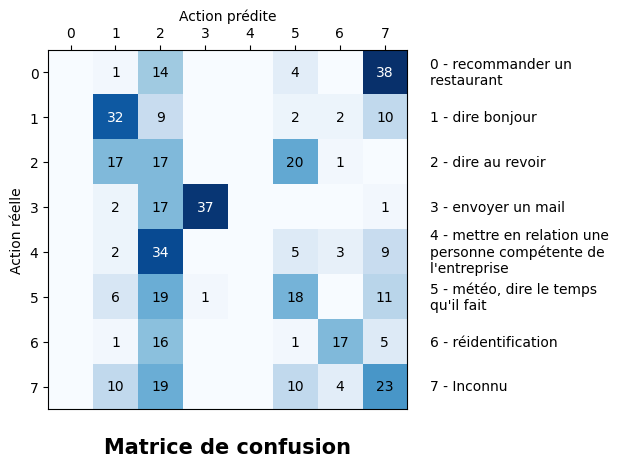


BAD PREDICTIONS --------------------------------------------------
Sentence - True Label - Predicted Label
-  Je connais quelques endroits sympas près de l'entreprise pour déjeuner. - recommander un restaurant - Unknown
-  Envie de découvrir de nouveaux restaurants à proximité ? - recommander un restaurant - Unknown
-  Besoin d'une idée pour déjeuner près d'ici ? - recommander un restaurant - dire au revoir
-  Tu cherches un bon endroit où manger dans le coin ? - recommander un restaurant - Unknown
-  Je peux te donner quelques suggestions de restaurants à proximité. - recommander un restaurant - Unknown
-  Tu veux des recommandations pour le déjeuner près du bureau ? - recommander un restaurant - dire au revoir
-  Besoin d'une pause déjeuner gourmande près d'ici ? - recommander un restaurant - Unknown
-  Je sais où trouver de bons restaurants dans les environs. - recommander un restaurant - Unknown
-  À la recherche d'une bonne table aux alentours ? - recommander un restaurant - dire

In [68]:
# now we have the similarity between each word and each action
# we can sum the similarities of all the words in a sentence to get the similarity between the sentence and the action

test_sentence_similarity_sum = np.zeros((len(TEST_SENTENCES), len(ACTION_LABELS)))
for n_word, (n_sentence, n_word_in_sentence) in tqdm(dict_senteces_word_indexes.items()):
    test_sentence_similarity_sum[n_sentence] += test_word_similarity[n_word] / len(sentences_words[n_sentence])

y_pred = np.array(np.argmax(test_sentence_similarity_sum, axis=1))
threshold = 0.4
y_pred[np.max(test_sentence_similarity, axis=0) < threshold] = 7
y_pred_str = decode_y(y_pred, dict_num_str)
y_pred_str = decode_y(y_pred, dict_num_str)

accuracy = (y_str == y_pred_str).mean()
print(f"Accuracy: {accuracy:.2f}")

# plot confusion matrix
plot_confusion_matrix(y_str, y_pred_str, y_str.unique())

# print bad predictions
print_bad_predictions(y_str, y_pred_str, X, X)

### RANDOM FOREST

Training accuracy: 1.0
Test accuracy: 0.9090909090909091


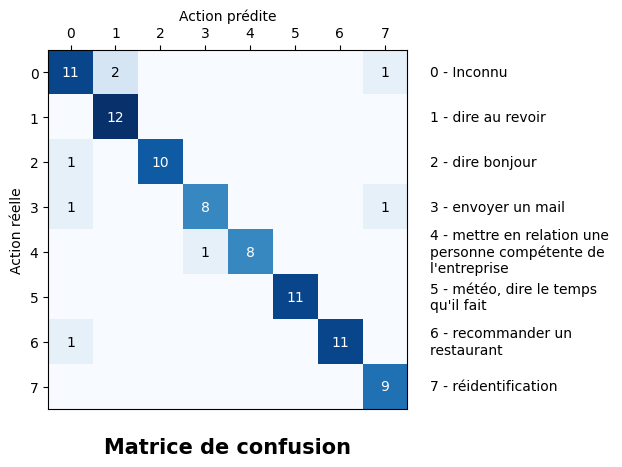


BAD PREDICTIONS --------------------------------------------------
Sentence - True Label - Predicted Label
-  Et pourquoi pas ? - Unknown - dire au revoir
-  Je ne suis pas sûr. - Unknown - réidentification
-  Prépare-toi à recevoir un e-mail de ma part. - envoyer un mail - Unknown
-  Oui ! - Unknown - dire au revoir
-  Envoyer un mail. - envoyer un mail - réidentification
-  Hey, quelles sont tes plans pour aujourd'hui ? - dire bonjour - Unknown
-  Besoin que je te présente à un spécialiste qui pourra te conseiller ? - mettre en relation une personne compétente de l'entreprise - envoyer un mail
-  Je vais t'assembler une liste de restaurants qui correspondent à tes goûts, ça te va ? - recommander un restaurant - Unknown


In [73]:
clf = RandomForestClassifier(random_state=0)
clf.fit(X_train, y_train)

y_proba = clf.predict_proba(X_test)

y_pred = clf.predict(X_test)

y_pred = np.array([y_pred[i] if y_proba[i, clf.classes_ == y_pred[i]] > 0.3 else 'Unknown' for i in range(len(y_pred))])

test_accuracy = np.mean(y_pred == y_test)

print(f"Training accuracy: {clf.score(X_train, y_train)}")
print(f"Test accuracy: {test_accuracy}")

plot_confusion_matrix(y_test, y_pred, clf.classes_)

print_bad_predictions(y_test, y_pred, X_test, X)

### NEURAL NETWORK

C:\Users\echriston\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_21 (Dense)                │ (None, 32)             │         2,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 8)              │           136 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,872 (11.22 KB)

 Trainable params: 2,872 (11.22 KB)

 Non-trainable params: 0 (0.00 B)

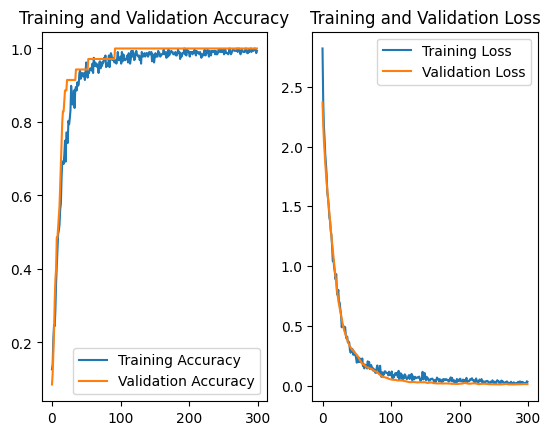

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
0       0       0       1.00    0       0       0       0       
0       0       0       0       0       0       1.00    0       
0       0       0       0       1.00    0       0       0       
0       0       0       0       0       1.00    0       0       
1.00    0       0       0       0       0       0       0       
1.00    0       0       0       0       0       0       0       
0       0       1.00    0       0       0       0       0       
0       0       0       0       0       1.00    0       0       
0       0       0       0       1.00    0       0       0       
0       0       0       0       0       1.00    0       0       
1.00    0       0       0       0       0       0       0       
0       0       0       1.00    0       0       0       0       
0.02    0.45    0.04    0.01    0.02    0.07    0       0.39    
0       0       0       0       0       1.00    0       0       
0       0       0       0       1.00    0       0   

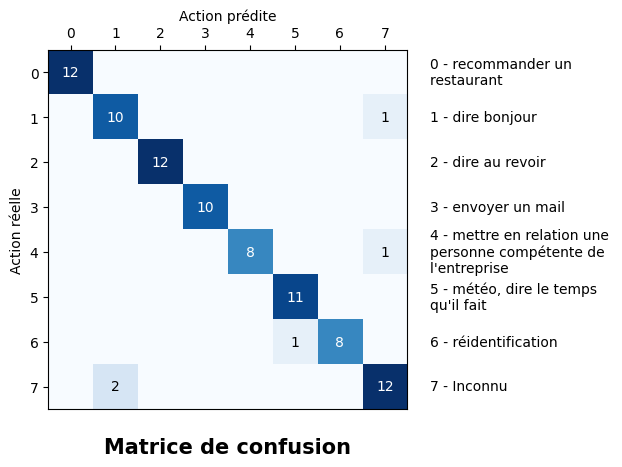


BAD PREDICTIONS --------------------------------------------------
Sentence - True Label - Predicted Label
-  J'ai eu une journée chargée, mais maintenant je peux enfin me détendre. - Unknown - dire bonjour
-  Et pourquoi pas ? - Unknown - dire bonjour
-  Désolé, il semble que je me sois trompé, je vais voir si je peux te reconnaître à nouveau. - réidentification - météo, dire le temps qu'il fait
-  Hey, quelles sont tes plans pour aujourd'hui ? - dire bonjour - Unknown
-  Besoin que je te présente à un spécialiste qui pourra te conseiller ? - mettre en relation une personne compétente de l'entreprise - Unknown


In [74]:
num_classes = len(y_str.unique())

model = Sequential([
    layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dropout(0.2),
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model.summary()

y_train_int = encode_y(y_train, dict_str_num)

epochs = 300
history = model.fit(X_train, y_train_int, epochs=epochs, validation_split=0.1, verbose=0)



acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure()
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()





y_pred_probas = model.predict(X_test)
# argmax if proba above threshold, else 'Unknown' (-100)
pretty_print_matrix(y_pred_probas, num_spaces=4)
y_pred_int = np.array([np.argmax(probas) if np.max(probas) > 0.3 else dict_str_num["Unknown"] for probas in y_pred_probas])
y_pred = decode_y(y_pred_int, dict_num_str)

test_accuracy = np.mean(y_pred == y_test)
print(f"Test accuracy: {test_accuracy}")

plot_confusion_matrix(y_test, y_pred, y_str.unique())

print_bad_predictions(y_test, y_pred, X_test, X)

In [75]:
# save the model
model.save(f"models/{MODEL_NAME}_model.h5")

## INFERENCE

In [136]:
# load the model
model = tf.keras.models.load_model(f"models/{MODEL_NAME}_model.h5")

# inference
sentence = "Hier j'ai reçu un mail pour un projet."
sentence_embedding_large = embedding_func(sentence)
sentence_similarity = np.array([cosine_similarity(sentence_embedding_large, action_embedding) for action_embedding in action_embeddings]).reshape(1, -1)
sentence_embedding = pca.transform(sentence_embedding_large.reshape(1, -1))
ponctuation_features = np.array([[(p in sentence) for p in ['.', ',', '?', '!']]]).astype(float)
words = new_words(sentence)
word_in_action_features = np.array([[np.any([word in action for word in words]) for action in ACTION_LABELS]]).astype(float)

X = np.concatenate([sentence_embedding, sentence_similarity, ponctuation_features, word_in_action_features], axis=1)
X = scaler.transform(X)
y_proba = model.predict(X)
y_str = decode_y(np.argmax(y_proba, axis=1), dict_num_str)[0]
print("Action probas")
pretty_print_matrix(y_proba, num_spaces=4)
print(f"Sentence: {sentence}")
print(f"Action: {y_str}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Action probas
0       0       0       0.05    0.91    0       0       0.03    
Sentence: Hier j'ai reçu un mail pour un projet.
Action: mettre en relation une personne compétente de l'entreprise
